# Northwestern County 1st Time Home Buyer Analysis

Author: Armun Shakeri

# Overview

This project analyzes homes available in today's housing market and examines which of those homes would be appropriate for a first time home buyer. Also how price of a home is affected by independent values like sqft_living and price. 

# Business Problem

Recently property values have been increasing throughout the United States. For those wanting to buy their first home,  there are many factors that might raise the price of that home. This project analyzes these factors and explores whether they have a positive or negative affect on price. 

# Data Understanding

The following data is imported from KC housing data and shows different information about homes such as the date a home was sold, price, bedrooms...etc. For this project we will only use some of the data available, others will be removed.

In [1]:
# Import standard packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.diagnostic import het_white
%matplotlib inline

In [2]:
# Run code to explore the data
kc = pd.read_csv('data/kc_house_data.csv')

In [3]:
# this shows information regarding variables in kc dataframe 
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Below we drop values that are irrelevant towards first time home buyer analysis 
# We will remove id since we will be making general recommendations 
# These values were dropped because they did not have a significant affect on the R-squared value of the baseline model.
# The only values included in the final model were values which had a significant affect on R-squared. 
kc = kc.drop(['id', 'date', 'sqft_living15', 'sqft_lot15', 'yr_built', 'long', 'floors', 'condition',
              'sqft_above', 'sqft_lot', 'waterfront', 'yr_renovated', 'view', 'zipcode'], axis=1)
kc.head()

,price,bedrooms,bathrooms,sqft_living,grade,sqft_basement,lat
0,221900.0,3,1.00,1180,7 Average,0.0,47.5112
1,538000.0,3,2.25,2570,7 Average,400.0,47.7210
2,180000.0,2,1.00,770,6 Low Average,0.0,47.7379
3,604000.0,4,3.00,1960,7 Average,910.0,47.5208
4,510000.0,3,2.00,1680,8 Good,0.0,47.6168


In [5]:
# Here we drop all Na values. 
kc=kc.dropna()

In [6]:
# First time home buyers will not be looking at homes over $1,000,000. Homes above that threshold will be removed. 
# Homes with bedrooms at or above 4, and greater than 2 floors will also be removed. 
kc = kc[kc.price<=1000000][kc.bedrooms<=10]
kc.head()

<ipython-input-6-4f7939aed66f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kc = kc[kc.price<=1000000][kc.bedrooms<=10]


,price,bedrooms,bathrooms,sqft_living,grade,sqft_basement,lat
0,221900.0,3,1.00,1180,7 Average,0.0,47.5112
1,538000.0,3,2.25,2570,7 Average,400.0,47.7210
2,180000.0,2,1.00,770,6 Low Average,0.0,47.7379
3,604000.0,4,3.00,1960,7 Average,910.0,47.5208
4,510000.0,3,2.00,1680,8 Good,0.0,47.6168


In [7]:
# create dummy variables for categoricals (waterfront, condition and grade)

categoricals = ['grade']

dummies = pd.get_dummies(kc[categoricals], prefix=categoricals, drop_first=True)     #create dummies and get rid of multicollinearity

kc = kc.drop(categoricals, axis=1)

kc = pd.concat([kc, dummies], axis=1)

kc.head()

,price,bedrooms,bathrooms,sqft_living,sqft_basement,lat,grade_11 Excellent,grade_12 Luxury,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
0,221900.0,3,1.00,1180,0.0,47.5112,0,0,0,0,0,0,1,0,0
1,538000.0,3,2.25,2570,400.0,47.7210,0,0,0,0,0,0,1,0,0
2,180000.0,2,1.00,770,0.0,47.7379,0,0,0,0,0,1,0,0,0
3,604000.0,4,3.00,1960,910.0,47.5208,0,0,0,0,0,0,1,0,0
4,510000.0,3,2.00,1680,0.0,47.6168,0,0,0,0,0,0,0,1,0


In [8]:
# Build correlation matrix
corr = kc.corr()
corr

,price,bedrooms,bathrooms,sqft_living,lat,grade_11 Excellent,grade_12 Luxury,grade_3 Poor,grade_4 Low,grade_5 Fair,grade_6 Low Average,grade_7 Average,grade_8 Good,grade_9 Better
price,1.000000,0.294976,0.439504,0.604233,0.440473,0.136924,0.020265,-0.007387,-0.047730,-0.123166,-0.286368,-0.307585,0.167157,0.363530
bedrooms,0.294976,1.000000,0.502797,0.604490,-0.037402,0.055566,0.013338,-0.018560,-0.071863,-0.116694,-0.241703,-0.069346,0.108768,0.163376
bathrooms,0.439504,0.502797,1.000000,0.711397,-0.017073,0.103674,0.043785,-0.012936,-0.059047,-0.145345,-0.379786,-0.268447,0.277797,0.294854
sqft_living,0.604233,0.604490,0.711397,1.000000,0.000587,0.166648,0.053688,-0.013392,-0.061833,-0.141939,-0.339310,-0.318204,0.176764,0.394299
lat,0.440473,-0.037402,-0.017073,0.000587,1.000000,0.013578,-0.009142,-0.017298,-0.015461,-0.043962,-0.054520,-0.017203,0.036849,0.027346
grade_11 Excellent,0.136924,0.055566,0.103674,0.166648,0.013578,1.000000,-0.000675,-0.000477,-0.002482,-0.007472,-0.022702,-0.060590,-0.043471,-0.023871
grade_12 Luxury,0.020265,0.013338,0.043785,0.053688,-0.009142,-0.000675,1.000000,-0.000070,-0.000365,-0.001099,-0.003340,-0.008914,-0.006395,-0.003512
grade_3 Poor,-0.007387,-0.018560,-0.012936,-0.013392,-0.017298,-0.000477,-0.000070,1.000000,-0.000258,-0.000777,-0.002362,-0.006303,-0.004522,-0.002483
grade_4 Low,-0.047730,-0.071863,-0.059047,-0.061833,-0.015461,-0.002482,-0.000365,-0.000258,1.000000,-0.004041,-0.012279,-0.032771,-0.023512,-0.012911
grade_5 Fair,-0.123166,-0.116694,-0.145345,-0.141939,-0.043962,-0.007472,-0.001099,-0.000777,-0.004041,1.000000,-0.036959,-0.098639,-0.070769,-0.038861


In [9]:
# remove spacing in grade column to help with baseline model 

kc.columns = [grade.replace(' ', '') for grade in kc.columns]

# Data Modeling

In [10]:
# Here shows the different statistical values of the kc dataframe
kc.describe()

,price,bedrooms,bathrooms,sqft_living,lat,grade_11Excellent,grade_12Luxury,grade_3Poor,grade_4Low,grade_5Fair,grade_6LowAverage,grade_7Average,grade_8Good,grade_9Better
count,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000,20137.000000
mean,467959.730744,3.320753,2.039269,1955.546854,47.555948,0.004569,0.000099,0.000050,0.001341,0.012018,0.100958,0.444406,0.291652,0.110443
std,196500.701772,0.881183,0.702399,755.455700,0.141673,0.067439,0.009966,0.007047,0.036593,0.108967,0.301281,0.496912,0.454534,0.313449
min,78000.000000,1.000000,0.500000,370.000000,47.155900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,314500.000000,3.000000,1.500000,1390.000000,47.457600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,435000.000000,3.000000,2.000000,1840.000000,47.565800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,594000.000000,4.000000,2.500000,2410.000000,47.680100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1000000.000000,10.000000,7.500000,7480.000000,47.777600,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


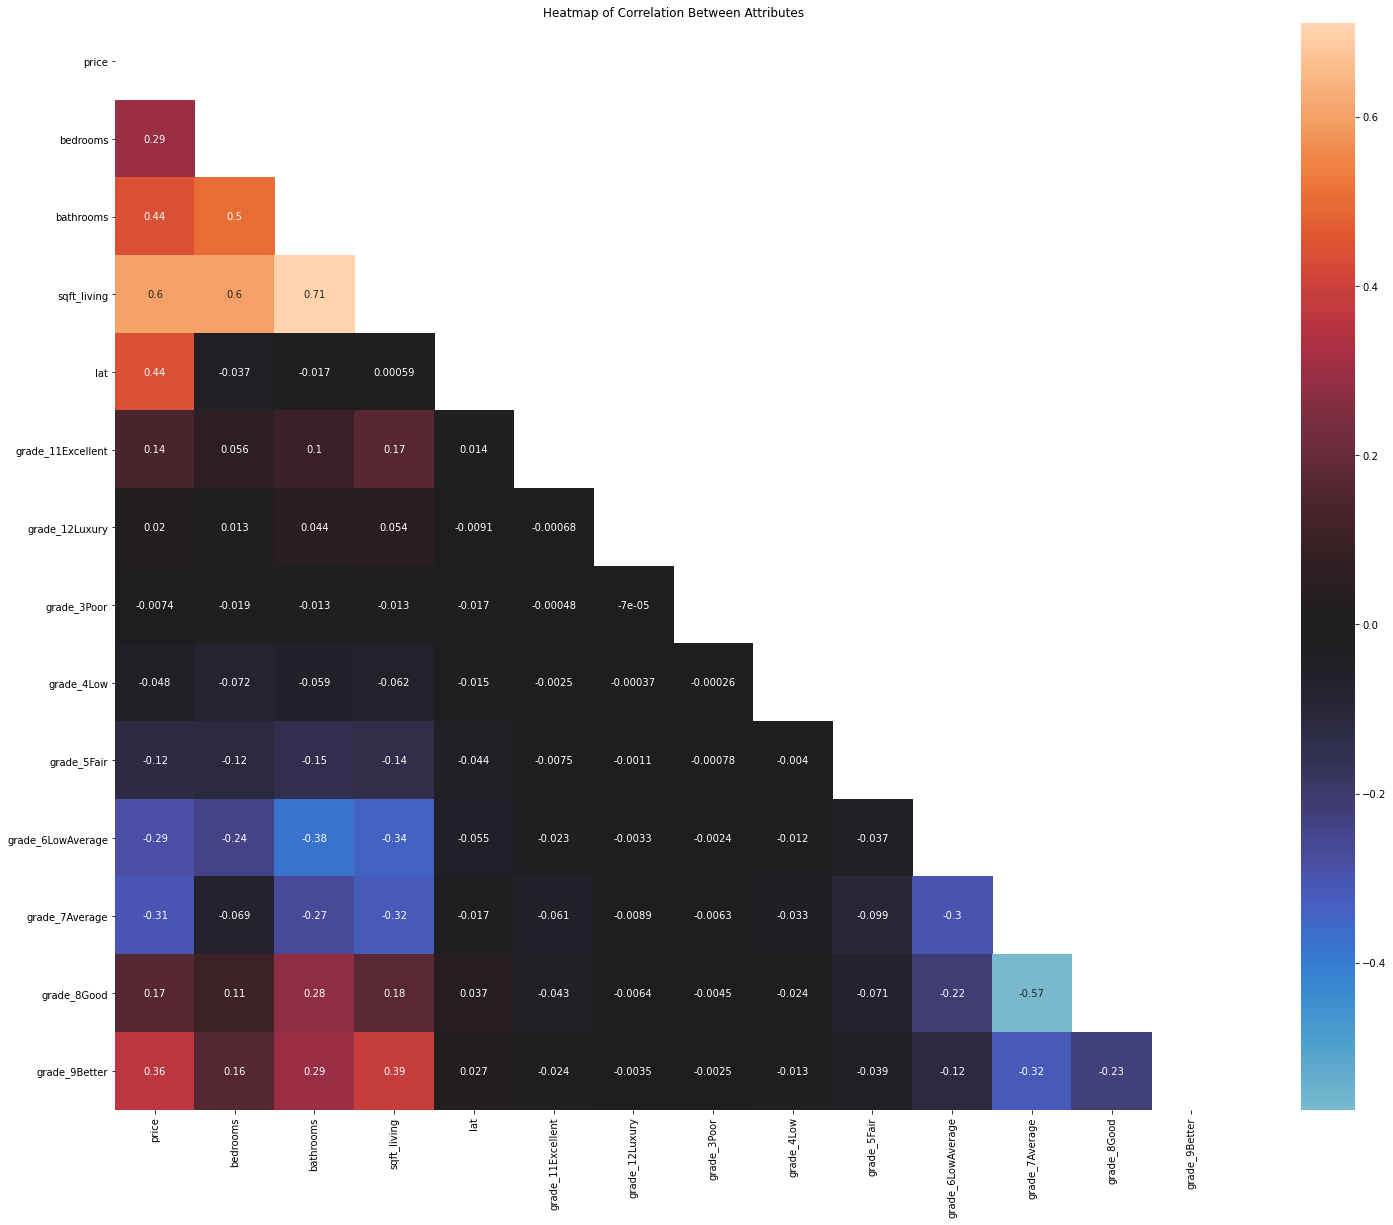

In [11]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(kc.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            center=0);

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes");

# We see below that the highest to lowest correlated are as follows:
# 1) sqft_living x bathrooms
# 2) price x sqft_living
# 3) price x bathrooms

In [12]:
# Model displays low R-squared value, will need to add more values to raise R-squared
b = 'price~sqft_living'

model = ols(formula=b, data=kc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                 1.158e+04
Date:                Sat, 30 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:17:49   Log-Likelihood:            -2.6944e+05
No. Observations:               20137   AIC:                         5.389e+05
Df Residuals:                   20135   BIC:                         5.389e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.606e+05   3061.997     52.454      0.000    1.55e+05    1.67e+05
sqft_living   157.1663      1.461    107.604      0.000     154.303     160.029
==============================================================================
Omnibus:                      704.336   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              780.586
Skew:                           0.482   Prob(JB):                    3.15e-170
Kurtosis:                       2.974   Cond. No.                     5.82e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
# After adding lat, bathrooms, and grade R-squared now has a value of .615

b = 'price~bedrooms+bathrooms+sqft_living+lat+grade_11Excellent+grade_12Luxury+grade_3Poor+grade_4Low+grade_5Fair+grade_6LowAverage+grade_7Average+grade_8Good'

model = ols(formula=b, data=kc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     2682.
Date:                Sat, 30 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:17:49   Log-Likelihood:            -2.6439e+05
No. Observations:               20137   AIC:                         5.288e+05
Df Residuals:                   20124   BIC:                         5.289e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2.706e+07   2.91e+05    -92.858      0.000   -2.76e+07   -2.65e+07
bedrooms          -6085.4856   1275.033     -4.773      0.000   -8584.654   -3586.317
bathrooms         -7628.5903   1853.886     -4.115      0.000   -1.13e+04   -3994.822
sqft_living         108.9374      2.073     52.551      0.000     104.874     113.001
lat                5.777e+05   6114.721     94.476      0.000    5.66e+05     5.9e+05
grade_11Excellent  6.732e+04    1.3e+04      5.179      0.000    4.18e+04    9.28e+04
grade_12Luxury    -6.157e+04   8.64e+04     -0.712      0.476   -2.31e+05    1.08e+05
grade_3Poor        3774.5393   1.22e+05      0.031      0.975   -2.35e+05    2.43e+05
grade_4Low        -2.253e+05   2.39e+04     -9.438      0.000   -2.72e+05   -1.79e+05
grade_5Fair       -2.172e+05   8803.942    -24.673      0.000   -2.34e+05      -2e+05
grade_6LowAverage -2.048e+05   4623.249    -44.297      0.000   -2.14e+05   -1.96e+05
grade_7Average    -1.623e+05   3364.266    -48.252      0.000   -1.69e+05   -1.56e+05
grade_8Good       -9.654e+04   3048.458    -31.667      0.000   -1.03e+05   -9.06e+04
==============================================================================
Omnibus:                     1965.906   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3026.105
Skew:                           0.734   Prob(JB):                         0.00
Kurtosis:                       4.204   Cond. No.                     7.11e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

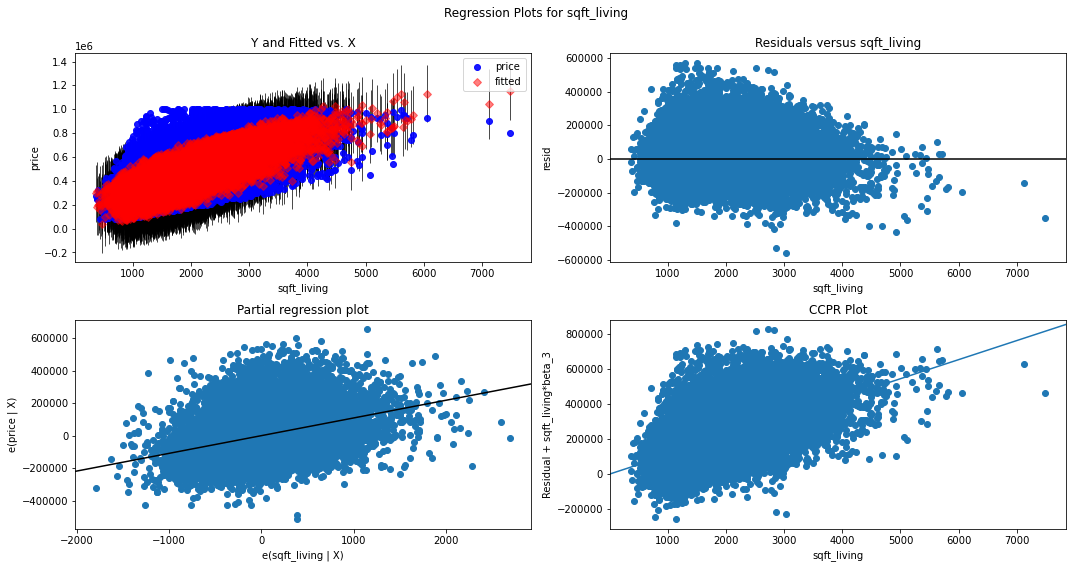

In [14]:
# Visualize terms, specifically sqft_living

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

# the positive correlation in Y and Fitted vs. X graph shows that sqft_living and price are correlated. 
# this is heteroscedastic 

<AxesSubplot:>

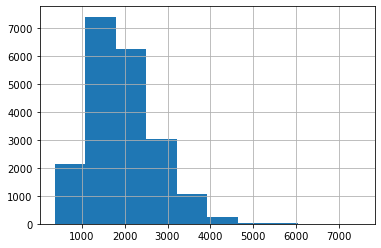

In [15]:
# sqft_living seems fairly normally distributed, slight skew to the left

kc['sqft_living'].hist()

<AxesSubplot:>

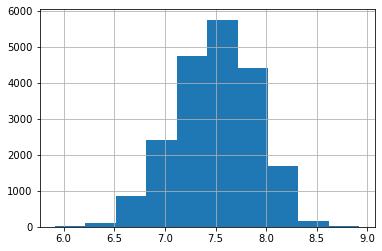

In [16]:
# in order to scale this distribution we will need to perform a log transform 

kc['log_sqft_living'] = np.log(kc['sqft_living'])
kc['log_sqft_living'].hist()

<AxesSubplot:>

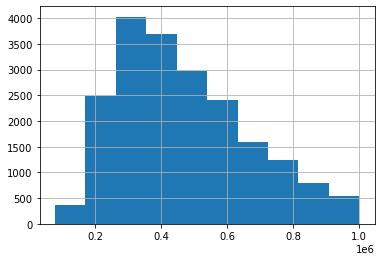

In [17]:
# price is more skewed to the left 

kc['price'].hist()

<AxesSubplot:>

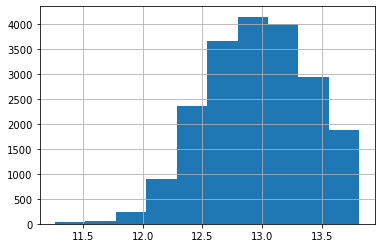

In [18]:
# log transformation for price

kc['log_price'] = np.log(kc['price'])
kc['log_price'].hist()

In [19]:
# final model

b2 = 'log_price~bedrooms+bathrooms+log_sqft_living+lat+grade_11Excellent+grade_12Luxury+grade_3Poor+grade_4Low+grade_5Fair+grade_6LowAverage+grade_7Average+grade_8Good'

model2 = ols(formula=b2, data=kc).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     3021.
Date:                Sat, 30 Apr 2022   Prob (F-statistic):               0.00
Time:                        14:17:51   Log-Likelihood:                -1428.9
No. Observations:               20137   AIC:                             2884.
Df Residuals:                   20124   BIC:                             2987.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -58.1557      0.626    -92.934      0.000     -59.382     -56.929
bedrooms             -0.0225      0.003     -8.131      0.000      -0.028      -0.017
bathrooms            -0.0049      0.004     -1.232      0.218      -0.013       0.003
log_sqft_living       0.4673      0.009     53.676      0.000       0.450       0.484
lat                   1.4286      0.013    109.581      0.000       1.403       1.454
grade_11Excellent     0.0971      0.028      3.521      0.000       0.043       0.151
grade_12Luxury        0.1419      0.184      0.771      0.440      -0.219       0.503
grade_3Poor           0.2935      0.260      1.128      0.259      -0.216       0.804
grade_4Low           -0.5245      0.051    -10.248      0.000      -0.625      -0.424
grade_5Fair          -0.5106      0.019    -26.821      0.000      -0.548      -0.473
grade_6LowAverage    -0.4296      0.010    -43.235      0.000      -0.449      -0.410
grade_7Average       -0.3156      0.007    -45.840      0.000      -0.329      -0.302
grade_8Good          -0.1699      0.006    -27.144      0.000      -0.182      -0.158
==============================================================================
Omnibus:                      213.780   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              338.894
Skew:                           0.087   Prob(JB):                     2.57e-74
Kurtosis:                       3.611   Cond. No.                     1.65e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<ipython-input-20-963a3d7f22ff>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


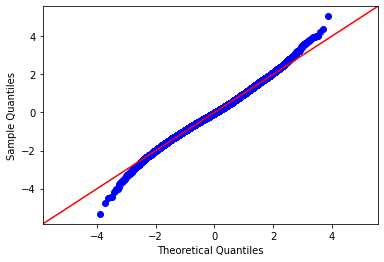

In [20]:
residuals = model2.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

# Q-Q plot shows normality of distribution 

<AxesSubplot:>

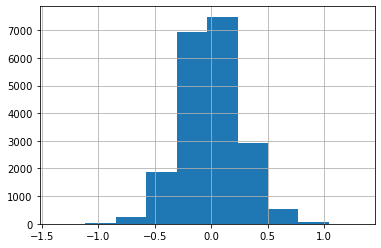

In [21]:
# This histogram shows the normal distribution

residuals.hist()

In [22]:
# Perform White's test 

white_test = het_white(model2.resid, model2.model.exog)

# define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

# print results of White's test
print(dict(zip(labels, white_test)))

# p-value is extremely small which shows that the residuals are homoscedastic and therefore evenly distributed

{'Test Statistic': 1342.8931121576256, 'Test Statistic p-value': 1.9396904633888092e-250, 'F-Statistic': 30.540786332343547, 'F-Test p-value': 6.543692649011736e-260}


In [23]:
residuals = model2.resid

In [25]:
X = kc.drop(['price', 'log_price'], axis=1)

y_pred = model2.predict(X)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

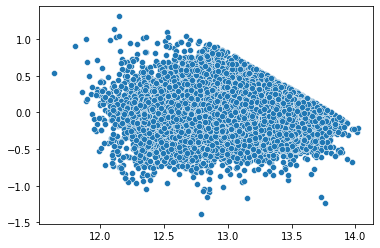

In [26]:
sns.scatterplot(y_pred,residuals)

#meets assumptions

# Evaluation 

From the analysis above there is a trend among current homes listed for sale in today's housing market 
and the different features regarding those homes. For first time home buyers we wanted to only focus 
on the affects different features have on price. We found that the highest correlated features 
in the housing market compared to price were sqft_living, bathrooms and latitude of the home respectively. 

The first step of analysis was to clean the data. We wanted to exclude features that would be irrelevant for 
the majority of homebuyers such as the id of the home and if the home had a waterfront or not. From there we 
also excluded homes with a price greater than 1000000 and homes with bedrooms greater than 10. After creating 
the baseling model and heatmap we saw that sqft_living and price were not scaled properly, we performed log 
transforms on both features to fix this issue and scale both of features. We then could begin performing 
White's test to test for homoscedasticity. We saw that the p-value was extremely small,
'Test Statistic p-value': 1.9396904633888092e-250, which showed that the residuals were homoscedastic and 
thus evenly distributed, meaning that assumptions for homoscedasticity met. 

These models can be generalized beyond the data that was presented. During analysis we left out location of
the homes that were on the market. When examining the heatmap above we saw that there was a high correlation 
between latitude of the homes and price. A first time home buyer could use this information when comparing 
different homes and can possibly make a better descision for the location of their first home. 

# Conclusion

The following below are recommendations for a first time home buyer: 
    
    1) For every 1% increase in sqft_living price will experience a .46% price increase. 
    
    2) Homes with grades of 4, 5, 6, 7, and 8 have a negative affect on price while 
       homes with grades of 3 12 and 11 have a positive affect on price. 

    3) Bathrooms do not have an affect on the homes price. 

This analysis still might not fully answer every question a first time home buyer will have since it leaves
out outliers and location features of homes. In the future we could include more location features such as 
zipcode, latitude and longitude to help first time home buyers explore different homes within kc county 
that might have been left out. 